Anna Marjankowska, Adrian Żyła

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids, AllKNN
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from imblearn.metrics import specificity_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import shap
shap.initjs()



# Roczny dochód obywateli USA

Celem projektu jest przeprowadzenie **analizy eksploracyjnej danych** dotyczących dochodów obywateli USA oraz **budowa modeli predykcyjnych** w celu przewidywania poziomu dochodów. Analiza ma na celu zrozumienie kluczowych czynników wpływających na dochody oraz **ocenę interpretowalności zastosowanych modeli**. 

Źródło danych: https://www.kaggle.com/datasets/amirhosseinmirzaie/americancitizenincome/data

## 1. Wczytanie oraz analiza danych.

### Opis zmiennych w zbiorze danych

- **`age`**: Wiek osoby.  
- **`workclass`**: Status zatrudnienia (np. pracownik sektora prywatnego, rządowego itp.).  
- **`fnlwgt`**: Waga reprezentatywna danej osoby w próbie.  
- **`education`**: Najwyższy poziom wykształcenia osiągnięty przez osobę (np. "Bachelors").  
- **`education.num`**: Liczbowy odpowiednik poziomu wykształcenia.  
- **`marital.status`**: Status cywilny (np. "Married-civ-spouse" - małżonek cywilny).  
- **`occupation`**: Typ zawodu (np. "Tech-support", "Craft-repair").  
- **`relationship`**: Relacja osoby z innymi (np. "Husband", "Own-child").  
- **`race`**: Rasa osoby (np. "White", "Black").  
- **`sex`**: Płeć biologiczna ("Male", "Female").  
- **`capital.gain`**: Dochody kapitałowe (zyski).  
- **`capital.loss`**: Straty kapitałowe.  
- **`hours.per.week`**: Liczba przepracowanych godzin tygodniowo.  
- **`native.country`**: Kraj pochodzenia osoby (np. "United-States").  
- **`income`**: Dochód osoby w jednej z dwóch kategorii: ≤50K lub >50K.


In [2]:
df = pd.read_csv("./income.csv")

In [3]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,United-States,>50K
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,United-States,>50K
4,54,?,148657,Preschool,1,Married-civ-spouse,?,Wife,White,Female,0,0,40,Mexico,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   fnlwgt          25000 non-null  int64 
 3   education       25000 non-null  object
 4   education.num   25000 non-null  int64 
 5   marital.status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital.gain    25000 non-null  int64 
 11  capital.loss    25000 non-null  int64 
 12  hours.per.week  25000 non-null  int64 
 13  native.country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB


### Podstawowe statystyki zmiennych ilościowych

In [5]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,25000.00000,2.500000e+04,25000.000000,25000.000000,25000.000000,25000.000000
mean,38.60916,1.896611e+05,10.076320,1083.144040,87.489800,40.442800
std,13.68660,1.054713e+05,2.576967,7321.971568,402.830246,12.309706
min,17.00000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.00000,1.179830e+05,9.000000,0.000000,0.000000,40.000000
50%,37.00000,1.782110e+05,10.000000,0.000000,0.000000,40.000000
75%,48.00000,2.370682e+05,12.000000,0.000000,0.000000,45.000000
max,90.00000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
def categorical_value_counts(data):
    categorical_cols = data.select_dtypes(include=['object']).columns 
    value_counts = {col: data[col].value_counts() for col in categorical_cols}
    return value_counts 

In [7]:
value_counts = categorical_value_counts(df)

for col, counts in value_counts.items():
    print(f"\nColumn: {col}")
    print(counts)



Column: workclass
workclass
Private             17471
Self-emp-not-inc     1935
Local-gov            1553
?                    1429
State-gov            1004
Self-emp-inc          851
Federal-gov           740
Without-pay            12
Never-worked            5
Name: count, dtype: int64

Column: education
education
HS-grad         8025
Some-college    5621
Bachelors       4104
Masters         1301
Assoc-voc       1063
11th             905
Assoc-acdm       809
10th             736
7th-8th          476
Prof-school      449
9th              403
12th             344
Doctorate        328
5th-6th          265
1st-4th          135
Preschool         36
Name: count, dtype: int64

Column: marital.status
marital.status
Married-civ-spouse       11518
Never-married             8204
Divorced                  3390
Separated                  792
Widowed                    766
Married-spouse-absent      312
Married-AF-spouse           18
Name: count, dtype: int64

Column: occupation
occupation
Prof-sp

In [8]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [9]:
df[df == "?"].count()

age                  0
workclass         1429
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1434
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     437
income               0
dtype: int64

### Braki w danych oraz zależność zmiennych
Zaobserwowaliśmy, że w zmiennych **`workclass`**, **`occupation`** oraz **`native.region`** występują braki danych, reprezentowane jako `?`. Aby lepiej zrozumieć te braki, sprawdzimy zależności pomiędzy tymi zmiennymi.

Do analizy zastosujemy miarę **V-Cramera**, która pozwoli określić siłę zależności pomiędzy zmiennymi kategorycznymi. Wyniki tej analizy pomogą nam podjąć decyzję, jak radzić sobie z brakami w danych oraz które zmienne uwzględnić w modelu.


In [10]:
# Funkcja do obliczania V-Cramera
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def cramers_v_output(v_cramer, variable1, variable2):
    print(f"V-Cramer dla zmiennych {variable1} & {variable2}: {v_cramer}")

    # Interpretacja wyniku
    if v_cramer < 0.1:
        print("Bardzo słaba zależność\n")
    elif v_cramer < 0.3:
        print("Słaba zależność\n")
    elif v_cramer < 0.5:
        print("Umiarkowana zależność\n")
    else:
        print("Silna zależność\n")

In [11]:
contingency_tables = {
    'relationship_marital.status': pd.crosstab(df['relationship'], df['marital.status']),
    'workclass_occupation': pd.crosstab(df['workclass'], df['occupation']),
    'race_native.country': pd.crosstab(df['race'], df['native.country'])
}

for table_name, table in contingency_tables.items():
    v_cramer = cramers_v(table)
    variable1, variable2 = table_name.split('_')
    cramers_v_output(v_cramer, variable1, variable2)

V-Cramer dla zmiennych relationship & marital.status: 0.4890628765894769
Umiarkowana zależność

V-Cramer dla zmiennych workclass & occupation: 0.39858811874024
Umiarkowana zależność

V-Cramer dla zmiennych race & native.country: 0.41116173339470086
Umiarkowana zależność



In [12]:
df[(df['occupation'] == "?") & (df['workclass'] != "?")]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
4445,18,Never-worked,153663,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
16567,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
19693,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
20686,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
24280,23,Never-worked,188535,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K


In [13]:
df[(df['occupation'] != "?") & (df['workclass'] == "?")]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income


Z analizy wynika, że zmienne **`workclass`** i **`occupation`** są umiarkowanie zależne. Co więcej, wartości brakujące (`?`) w tych zmiennych pojawiają się w tych samych wierszach. Może to sugerować, że braki w danych nie są przypadkowe i mogą wynikać z celowego zatajenia informacji.

Aby zachować spójność danych i nie tracić informacji, zamienimy wartości `?` w zmiennych **`workclass`** i **`occupation`** na nową kategorię **`unknown`**. Dzięki temu będziemy mogli uwzględnić te przypadki w dalszej analizie i modelowaniu.


In [14]:
df['occupation'].replace("?", "unknown", inplace=True)
df['workclass'].replace('?', 'unknown', inplace=True )


In [15]:
df[df == "?"].count()

age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    437
income              0
dtype: int64

Dla zmiennej **`native.country`** wartości brakujące (`?`) zostaną zamienione na **`NA`**, co umożliwi nam łatwe usunięcie tych wierszy ze zbioru danych.

In [16]:
df['native.country'].replace("?", np.nan, inplace=True)

In [17]:
df = df.dropna()

In [18]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Zweryfikujmy teraz zależność między zmiennymi **`native.country`** i **`race`**, aby sprawdzić, czy usunięcie brakujących wartości w zmiennej **`native.country`** wpłynęło na ich relację

In [19]:
contingency_tables = pd.crosstab(df['race'], df['native.country'])
v_cramer = cramers_v(contingency_tables)
cramers_v_output(v_cramer, 'race', 'native.country')

V-Cramer dla zmiennych race & native.country: 0.4236450220561596
Umiarkowana zależność



Usunięcie brakujących wartości ze zmiennej **`native.country`** **_nie wpłynęło na zależność_** ze zmienną **`race`**. Relacja między tymi zmiennymi pozostała niezmieniona, co wskazuje, że brakujące dane w **`native.country`** nie miały istotnego wpływu na rozkład zmiennej **`race`**.

### Połączenie zmiennych **`capital.loss`** i **`capital.gain`**

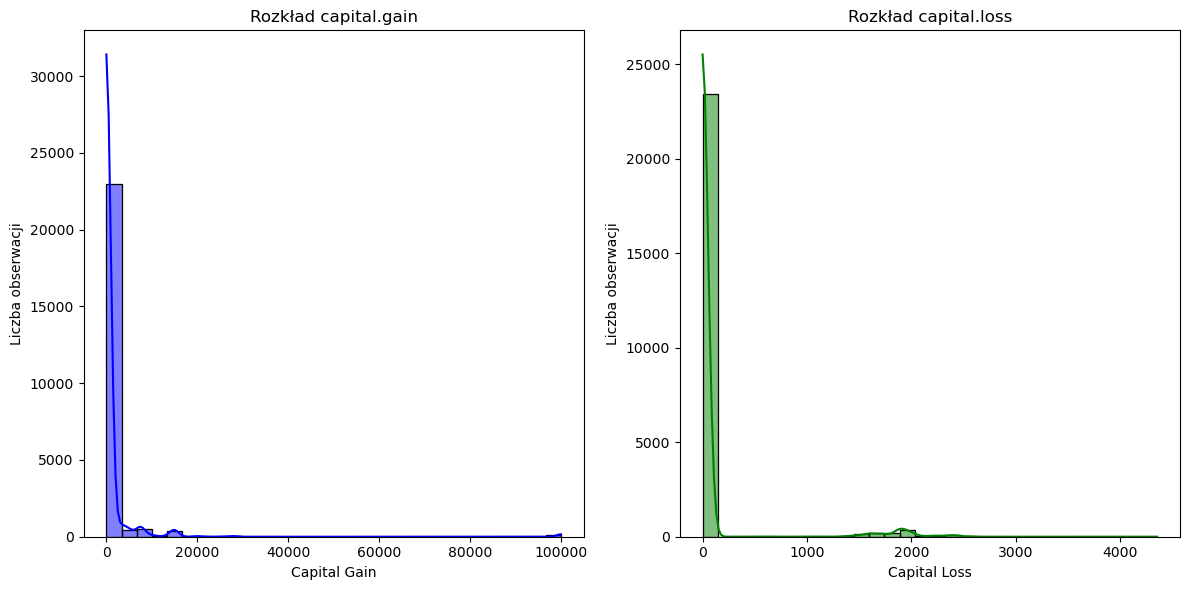

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['capital.gain'], bins=30, kde=True, color='blue')
plt.title('Rozkład capital.gain')
plt.xlabel('Capital Gain')
plt.ylabel('Liczba obserwacji')

plt.subplot(1, 2, 2)
sns.histplot(df['capital.loss'], bins=30, kde=True, color='green')
plt.title('Rozkład capital.loss')
plt.xlabel('Capital Loss')
plt.ylabel('Liczba obserwacji')

plt.tight_layout()
plt.show()

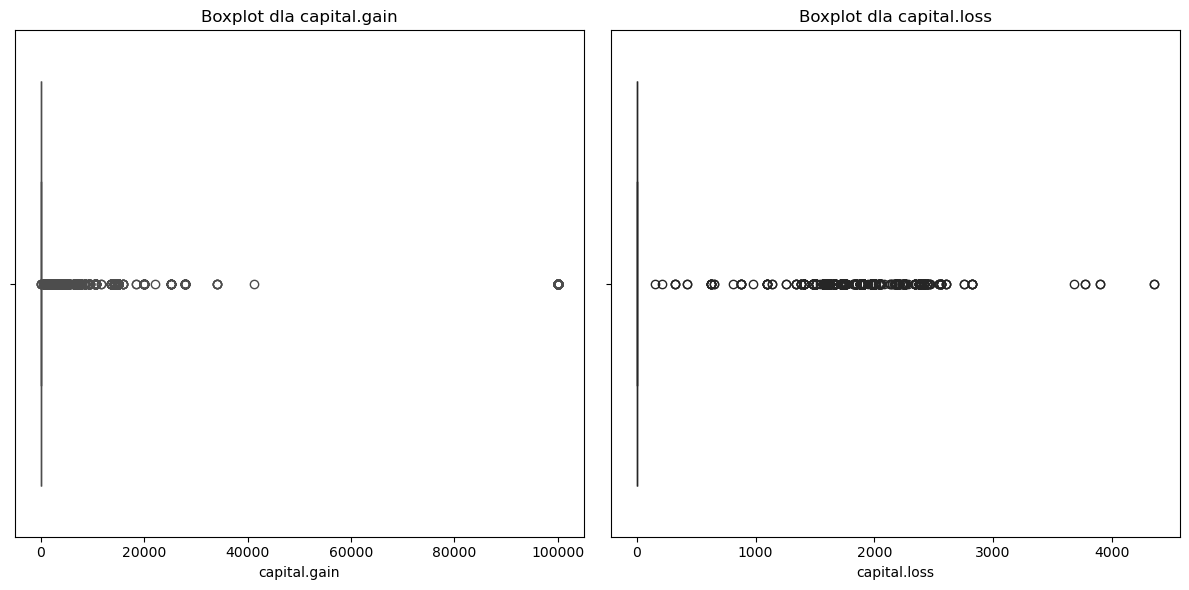

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['capital.gain'], color='blue')
plt.title('Boxplot dla capital.gain')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['capital.loss'], color='green')
plt.title('Boxplot dla capital.loss')

plt.tight_layout()
plt.show()

Z analizy wynika, że zmienne **`capital.loss`** oraz **`capital.gain`** są ze sobą zależne. Aby uprościć modelowanie i analizę, możemy połączyć te dwie zmienne w jedną, nazwaną **`net.capital`**, która będzie reprezentowała różnicę pomiędzy zyskami a stratami kapitałowymi:

$$
\text{net.capital} = \text{capital.gain} - \text{capital.loss}
$$

In [22]:
df.loc[:, 'net.capital'] = df['capital.gain'] - df['capital.loss']
print(df[['capital.gain', 'capital.loss', 'net.capital']].head())

   capital.gain  capital.loss  net.capital
0         99999             0        99999
1             0             0            0
2             0             0            0
3             0             0            0
4             0             0            0


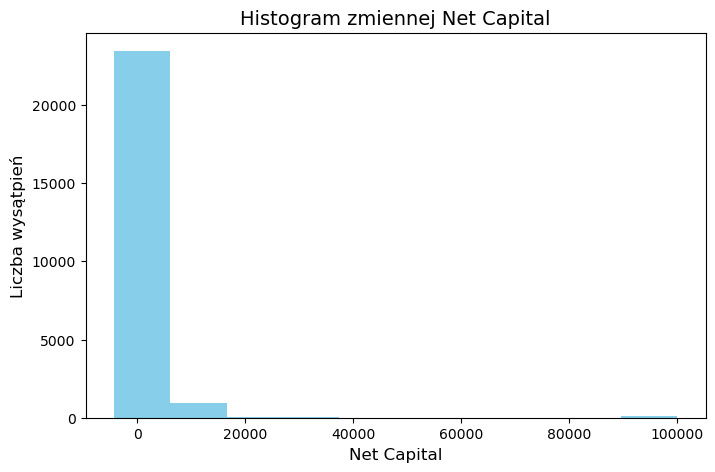

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(df['net.capital'], color='skyblue')

plt.title("Histogram zmiennej Net Capital", fontsize=14)
plt.xlabel("Net Capital", fontsize=12)
plt.ylabel("Liczba wysątpień", fontsize=12)

plt.show()

In [24]:
df.drop(columns=['capital.gain', 'capital.loss'])

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income,net.capital
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,70,United-States,>50K,99999
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,40,United-States,<=50K,0
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,40,United-States,>50K,0
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,60,United-States,>50K,0
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,40,Mexico,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,70,Private,278139,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,<=50K,3432
24995,40,Private,130834,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K,0
24996,31,Local-gov,33124,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,50,United-States,<=50K,0
24998,23,Private,420973,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,40,United-States,<=50K,0


### Uproszczenie zmiennej **`native.country`**

Zmienna **`native.country`** zawiera wiele kategorii, co może komplikować analizę i modelowanie. Aby uprościć tę zmienną, zdecydowaliśmy się zmapować ją do nowej zmiennej **`native.region`**, która grupuje kraje według ich regionów geograficznych.

Nowa zmienna **`native.region`** będzie stanowiła uproszczoną wersję **`native.country`** i pozwoli na bardziej przejrzystą analizę.


In [25]:
region_mapping = {
    'Cambodia': 'Asia',
    'Canada': 'North America',
    'China': 'Asia',
    'Columbia': 'South America',
    'Cuba': 'Caribbean',
    'Dominican-Republic': 'Caribbean',
    'Ecuador': 'South America',
    'El-Salvador': 'Central America',
    'England': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Greece': 'Europe',
    'Guatemala': 'Central America',
    'Haiti': 'Caribbean',
    'Honduras': 'Central America',
    'Hong': 'Asia',
    'Hungary': 'Europe',
    'India': 'Asia',
    'Iran': 'Middle East',
    'Ireland': 'Europe',
    'Italy': 'Europe',
    'Jamaica': 'Caribbean',
    'Japan': 'Asia',
    'Laos': 'Asia',
    'Mexico': 'North America',
    'Nicaragua': 'Central America',
    'Outlying-US(Guam-USVI-etc)': 'US Territories',
    'Peru': 'South America',
    'Philippines': 'Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Puerto-Rico': 'Caribbean',
    'Scotland': 'Europe',
    'South': 'Asia',
    'Taiwan': 'Asia',
    'Thailand': 'Asia',
    'Trinadad&Tobago': 'Caribbean',
    'United-States': 'North America',
    'Vietnam': 'Asia',
    'Yugoslavia': 'Europe'
}
df['native.region'] = df['native.country'].replace(region_mapping)

df = df.drop(columns=['native.country'])

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,income,net.capital,native.region
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,>50K,99999,North America
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,<=50K,0,North America
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,>50K,0,North America
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,>50K,0,North America
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,0,0,40,<=50K,0,North America


In [26]:
contingency_tables = pd.crosstab(df['race'], df['native.region'])
v_cramer = cramers_v(contingency_tables)
cramers_v_output(v_cramer, 'race', 'native.region')

V-Cramer dla zmiennych race & native.region: 0.40166173442827624
Umiarkowana zależność



Po zmapowaniu zmiennej **`native.country`** na zmienną **`native.region`** wciąż mamy umiarkowaną zależność.  

### Analiza zależności po mapowaniu zmiennych i ocena ich predykcyjnej mocy


Zmienne **native.region** & **race**, **workclass** & **occupation** oraz **relationship** & **marital.status** wykazują umiarkowaną zależność. Aby zdecydować, którą zmienną uwzględnić w modelu, obliczymy ich wartość **IV (Information Value)**.

#### Czym jest WOE i IV?

1. **Weight of Evidence (WOE)**  
WOE to miara różnic między rozkładami dwóch grup (np. "good" vs "bad"). Używana w modelach logistycznych, normalizuje dane i obliczana jest jako:

$$
WOE = \ln\left(\frac{\% \text{good}}{\% \text{bad}}\right)
$$

2. **Information Value (IV)**  
IV ocenia siłę predykcyjną zmiennej względem zmiennej celu, bazując na WOE:

$$
IV = \sum_{i=1}^{n} \left(\% \text{good}_i - \% \text{bad}_i\right) \cdot WOE_i
$$

**Interpretacja IV:**  
- IV < 0.02: brak predykcyjnej mocy,  
- 0.02 ≤ IV < 0.1: słaba,  
- 0.1 ≤ IV < 0.3: umiarkowana,  
- IV ≥ 0.3: silna.


**Dlaczego stosujemy WOE i IV?**  
- **WOE**: Normalizuje dane i zamienia zmienne kategoryczne na liczby dla modeli logistycznych.  
- **IV**: Identyfikuje zmienne o największej sile predykcyjnej. Pozwala rozróżnić, jak dobrze dana zmienna odróżnia grupy. Zmienna o wysokim IV lepiej pomaga w klasyfikacji, podczas gdy zmienna o niskim IV ma małą lub żadną moc predykcyjną.  

Obie miary pomagają w selekcji zmiennych, analizie danych i budowie stabilnych modeli.


Zamiana zmiennej **income** na zmienną binarną:

In [27]:
df = pd.get_dummies(df,columns=['income'], drop_first=True, dtype=int)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,net.capital,native.region,income_>50K
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,99999,North America,1
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,0,North America,0
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,0,North America,1
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,0,North America,1
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,0,0,40,0,North America,0


In [28]:
# Funkcja do obliczenia WoE i IV
def calculate_woe_iv(data, feature, target):

    df = data[[feature, target]].copy()
    total_good = df[target].sum() 
    total_bad = len(df) - total_good  
    
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped['bad'] = grouped['count'] - grouped['sum']
    grouped['good_dist'] = grouped['sum'] / total_good
    grouped['bad_dist'] = grouped['bad'] / total_bad

    grouped['woe'] = np.log((grouped['good_dist'] + 1e-6) / (grouped['bad_dist'] + 1e-6))
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']

    total_iv = grouped['iv'].sum()
    grouped = grouped.reset_index()
    return grouped, total_iv


In [29]:
# Obliczenie WoE i IV dla kolumny 'education'
dependent_col = ['native.region', 'race', 'workclass', 'occupation', 'relationship', 'marital.status']

for col in dependent_col:
    woe_iv_df, total_iv = calculate_woe_iv(df, col, 'income_>50K')
    print(f"\nWartość IV dla zmiennej {col}: {total_iv:.4f}")


Wartość IV dla zmiennej native.region: 0.0282

Wartość IV dla zmiennej race: 0.0627

Wartość IV dla zmiennej workclass: 0.1649

Wartość IV dla zmiennej occupation: 0.8165

Wartość IV dla zmiennej relationship: 1.5394

Wartość IV dla zmiennej marital.status: 1.3277


Na podstawie wartości **IV (Information Value)**, które wskazują siłę predykcyjną zmiennych, dokonano analizy, które zmienne z zależnych par należy pozostawić w modelu:

1. **Para: `native.region` i `race`**
   - **native.region**: IV = 0.0282 (bardzo niska predykcyjna moc).  
   - **race**: IV = 0.0627 (nadal niska, ale lepsza).  

**Decyzja**: Pozostawiamy zmienną **race**, ponieważ ma nieco wyższą wartość IV i lepszą predykcyjną moc.

2. **Para: `workclass` i `occupation`**
   - **workclass**: IV = 0.1649 (umiarkowana predykcyjna moc).  
   - **occupation**: IV = 0.8165 (silna predykcyjna moc).  

**Decyzja**: Pozostawiamy zmienną **occupation**, ponieważ ma znacznie wyższą wartość IV i lepiej wyjaśnia zmienną celu.

3. **Para: `relationship` i `marital.status`**
   - **relationship**: IV = 1.5394 (bardzo silna predykcyjna moc).  
   - **marital.status**: IV = 1.3277 (również bardzo silna, ale niższa). 
    
**Decyzja**: Pozostawiamy zmienną **relationship**, ponieważ ma najwyższą wartość IV spośród obu zmiennych.

### Analiza zbalansowania zbioru danych

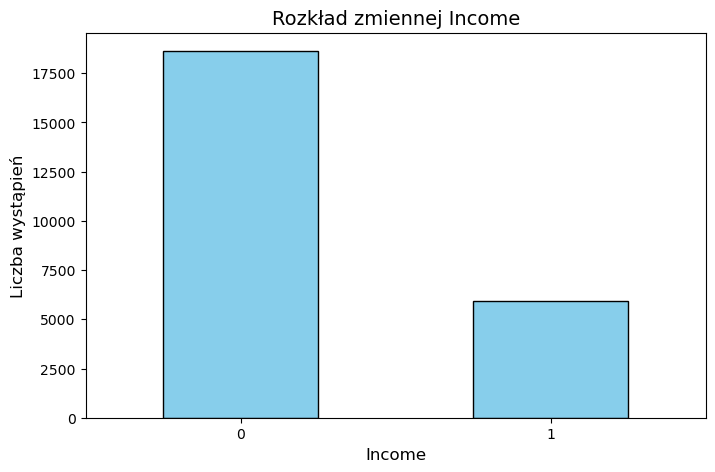

In [30]:
plt.figure(figsize=(8, 5))
df['income_>50K'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład zmiennej Income', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Liczba wystąpień', fontsize=12)
plt.xticks(rotation=0)  # Ustawienie etykiet osi X poziomo

# Wyświetlenie wykresu
plt.show()


In [31]:
positive_class_ratio = (df['income_>50K'].value_counts()[1] / df['income_>50K'].count()) * 100
print(f"Klasa pozytywna stanowi {positive_class_ratio:.2f}% całego zbioru danych.")


Klasa pozytywna stanowi 24.16% całego zbioru danych.


Obliczyliśmy, że klasa pozytywna w naszym zbiorze danych, reprezentująca osoby o dochodzie powyżej $50K rocznie (`income_>50K`), stanowi **24.67%** całego zbioru danych.

**Co to oznacza?**

- Klasa pozytywna jest **mniejszością** w porównaniu do klasy negatywnej (dochód ≤ $50K).  
- Nasz zbiór danych jest niezbalansowany, co może wpłynąć na wydajność modeli predykcyjnych. Modele mogą być bardziej skłonne do przewidywania klasy dominującej (negatywnej), ignorując klasę pozytywną.

In [32]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,net.capital,native.region,income_>50K
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,99999,North America,1
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,0,North America,0
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,0,North America,1
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,0,North America,1
4,54,unknown,148657,Preschool,1,Married-civ-spouse,unknown,Wife,White,Female,0,0,40,0,North America,0


## 2. Ostateczny wybór zmiennych oraz przygotowanie danych do budowy modelu

Na podstawie analizy zależności oraz wartości **IV (Information Value)**, dokonaliśmy wyboru zmiennych, które zostaną uwzględnione w modelu:

1. **Zależności i wybór zmiennych:**
   - **Para: `native.region` i `race`**  
     Wartości IV:  
     - `native.region`: **0.0282** (bardzo niska predykcyjna moc)  
     - `race`: **0.0627** (nadal niska, ale lepsza)  

     **Decyzja:** Pozostawiamy zmienną **race**, ponieważ ma wyższą wartość IV i lepszą predykcyjną moc.

   - **Para: `workclass` i `occupation`**  
     Wartości IV:  
     - `workclass`: **0.1649** (umiarkowana predykcyjna moc)  
     - `occupation`: **0.8165** (silna predykcyjna moc)  

     **Decyzja:** Pozostawiamy zmienną **occupation**, ponieważ ma znacznie wyższą wartość IV i lepiej wyjaśnia zmienną celu.

   - **Para: `relationship` i `marital.status`**  
     Wartości IV:  
     - `relationship`: **1.5394** (bardzo silna predykcyjna moc)  
     - `marital.status`: **1.3277** (również bardzo silna, ale niższa)  

     **Decyzja:** Pozostawiamy zmienną **relationship**, ponieważ ma najwyższą wartość IV spośród obu zmiennych.

2. **Zależność `education` i `education.num`:**
   Zmienna `education` (kategoria) i `education.num` (jej numeryczny odpowiednik) są w sposób oczywisty zależne.  
   **Decyzja:** Pozostawiamy zmienną **education.num**, ponieważ modele lepiej radzą sobie z wartościami liczbowymi.


In [33]:
df = df.drop(columns=['education', 'marital.status', 'capital.loss', 'capital.gain', 'native.region', 'workclass'])

In [34]:
df.head()

,age,fnlwgt,education.num,occupation,relationship,race,sex,hours.per.week,net.capital,income_>50K
0,40,223881,15,Prof-specialty,Husband,White,Male,70,99999,1
1,30,149118,9,Craft-repair,Not-in-family,White,Female,40,0,0
2,46,109209,10,Adm-clerical,Husband,White,Male,40,0,1
3,32,229566,11,Other-service,Husband,White,Male,60,0,1
4,54,148657,1,unknown,Wife,White,Female,40,0,0


In [35]:
def plot_confusion_matrix(y_true, y_pred, labels, cmap, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_with_labels = pd.DataFrame(conf_matrix, columns=labels, index=labels)
    sns.heatmap(conf_matrix_with_labels, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [36]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels=('0', '1'), cmap='Blues'):
    """
    Funkcja do obliczania i wyświetlania metryk modelu, wizualizacji macierzy konfuzji
    oraz wyświetlania raportu klasyfikacji.

    Parametry:
    - model: sklearn-like model
        Wytrenowany model predykcyjny.
    - X_train, Y_train: array-like
        Dane treningowe i ich etykiety.
    - X_test, Y_test: array-like
        Dane testowe i ich etykiety.
    - labels: tuple, optional
        Etykiety dla osi macierzy konfuzji (domyślnie ('0', '1')).
    - cmap: str, optional
        Kolorystyka mapy cieplnej (domyślnie 'Blues').

    Returns:
    - None
    """

    # Metryki dla danych treningowych
    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    auc_train = roc_auc_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    print('Metryki dla danych treningowych:')
    print(f'Accuracy: {acc_train:.4f}')
    print(f'AUC: {auc_train:.4f}')
    print(f'F1: {f1_train:.4f}')
    print('\nClassification Report dla danych treningowych:')
    print(classification_report(y_train, y_pred_train))

    # Wizualizacja macierzy konfuzji dla danych treningowych
    plot_confusion_matrix(y_train, y_pred_train, labels, cmap, 'Confusion Matrix (Train)')

    # Metryki dla danych testowych
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    print('\nMetryki dla danych testowych:')
    print(f'Accuracy: {acc_test:.4f}')
    print(f'AUC: {auc_test:.4f}')
    print(f'F1: {f1_test:.4f}')
    print('\nClassification Report dla danych testowych:')
    print(classification_report(y_test, y_pred_test))

    # Wizualizacja macierzy konfuzji dla danych testowych
    plot_confusion_matrix(y_test, y_pred_test, labels, cmap, 'Confusion Matrix (Test)')


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24563 entries, 0 to 24999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24563 non-null  int64 
 1   fnlwgt          24563 non-null  int64 
 2   education.num   24563 non-null  int64 
 3   occupation      24563 non-null  object
 4   relationship    24563 non-null  object
 5   race            24563 non-null  object
 6   sex             24563 non-null  object
 7   hours.per.week  24563 non-null  int64 
 8   net.capital     24563 non-null  int64 
 9   income_>50K     24563 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 2.1+ MB


### Zamiana zmiennych kategorycznych na zmienne binarne

W celu przygotowania danych do modelowania, zmienne kategoryczne **`occupation`**, **`relationship`**, **`race`**, oraz **`sex`** zostaną przekształcone na zmienne binarne za pomocą metody **one hot encoding**.

In [38]:
columns = ['occupation', 'relationship', 'race', 'sex']
df = pd.get_dummies(df,columns=columns, drop_first=True, dtype=int)
df.head()

,age,fnlwgt,education.num,hours.per.week,net.capital,income_>50K,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,40,223881,15,70,99999,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,30,149118,9,40,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,46,109209,10,40,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,32,229566,11,60,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,54,148657,1,40,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### Podział zmiennych na dane treningowe i testowe
Dokonujemy podziału danych na zestawy treningowy i testowy, aby zapewnić, że zbiór testowy pozostaje "niewidoczny" podczas procesu przygotowania danych i modelowania.

In [39]:
X = df.drop(columns=['income_>50K'])
y = df['income_>50K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Zbalansowanie zbioru danych

Zastosujmy połączenie metody **SMOTE** z **Tomek Links**.

In [40]:
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

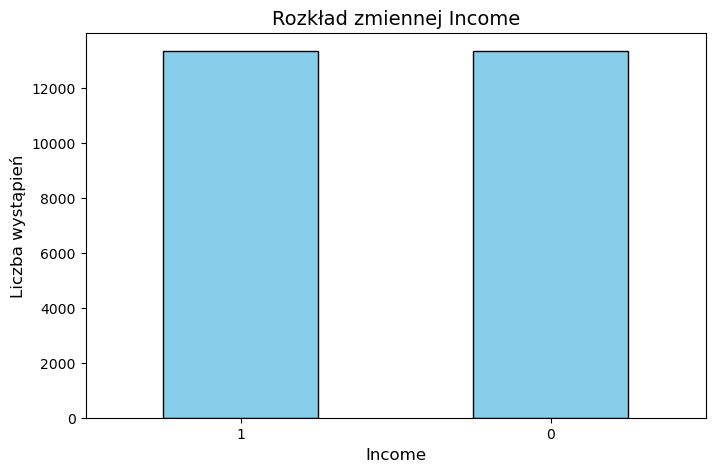

In [41]:
plt.figure(figsize=(8, 5))
y_resampled.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład zmiennej Income', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Liczba wystąpień', fontsize=12)
plt.xticks(rotation=0)  

plt.show()

### Skalowanie danych

Teraz przystąpimy do skalowania danych. Skalowanie jest konieczne, aby znormalizować wartości cech i zapewnić, że wszystkie zmienne są na tej samej skali. Jest to szczególnie ważne w przypadku algorytmów, które są wrażliwe na różnice w skali cech, takich jak SVM, kNN czy regresja logistyczna.

**Proces:**
1. Fitujemy skaler na zbiorze treningowym, aby dopasować go do danych treningowych.  
2. Skalujemy zarówno zbiór treningowy, jak i testowy, używając skalera wytrenowanego na zbiorze treningowym.  

Dzięki temu unikniemy przeciekania informacji ze zbioru testowego do modelu i zapewnimy poprawność procesu walidacji.


In [42]:
scaler = StandardScaler()
X_resampled[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']] = scaler.fit_transform(X_resampled[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']])
X_test[['fnlwgt', 'education.num','hours.per.week', 'net.capital',  'age']] = scaler.transform(X_test[['fnlwgt', 'education.num','hours.per.week', 'net.capital', 'age']])

In [43]:
df.describe()

,age,fnlwgt,education.num,hours.per.week,net.capital,income_>50K,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
count,24563.000000,2.456300e+04,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,...,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000,24563.000000
mean,38.610837,1.895654e+05,10.067418,40.427432,979.171315,0.241624,0.000244,0.125514,0.124740,0.031226,...,0.253756,0.029475,0.156658,0.106624,0.047999,0.030045,0.095469,0.007979,0.856247,0.667915
std,13.708100,1.056348e+05,2.565138,12.308670,7237.756530,0.428076,0.015628,0.331308,0.330431,0.173931,...,0.435168,0.169138,0.363486,0.308641,0.213769,0.170715,0.293867,0.088973,0.350846,0.470971
min,17.000000,1.228500e+04,1.000000,1.000000,-4356.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.177790e+05,9.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,1.779950e+05,10.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,48.000000,2.373790e+05,12.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,90.000000,1.484705e+06,16.000000,99.000000,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Budowa modelu - lasy losowe

### Random Forest Classifier
W przypadku modelu **Random Forest Classifier** zastosowano wyszukiwanie optymalnych parametrów przy użyciu **GridSearchCV**. Główne hiperparametry i ich znaczenie to:

- **n_estimators**:  
  Liczba drzew w lesie. Większa liczba drzew poprawia stabilność modelu, ale zwiększa czas obliczeń.  
  Testowano wartości `[3, 5, 10, 20, 30]`.

- **max_depth**:  
  Maksymalna głębokość drzew decyzyjnych. Ograniczenie głębokości zapobiega przeuczeniu, zwłaszcza w przypadku małych zbiorów danych.  
  Sprawdzono wartości `[5, 10, 15, 20]`.

- **min_samples_split**:  
  Minimalna liczba próbek wymagana do podziału węzła. Wyższe wartości zwiększają ogólną złożoność drzew i mogą zapobiec nadmiernemu dopasowaniu.  
  Testowano wartości `[10, 20, 30]`.

- **min_samples_leaf**:  
  Minimalna liczba próbek wymagana w liściu drzewa. Większe wartości mogą poprawić generalizację modelu.  
  Sprawdzono wartości `[10, 20]`.

- **criterion**:  
  Funkcja oceniająca jakość podziału. Porównano dwa kryteria:
  - **gini**: wskaźnik Giniego
  - **entropy**: informacja wzajemna  


In [44]:
model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [3, 5, 10, 20, 30],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [10, 20],
    'criterion': ['gini', 'entropy']
}


In [45]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,  
    verbose=2, 
    n_jobs=-1  
)

In [46]:
grid_search.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=3; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=3; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=3; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=3; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=3; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [3, 5, 10, 20, 30]},
             scoring='accuracy', verbose=2)

In [47]:
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik: {grid_search.best_score_:0.2f}")

Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 30}
Najlepszy wynik: 0.88


Metryki dla danych treningowych:
Accuracy: 0.8975
AUC: 0.8975
F1: 0.8980

Classification Report dla danych treningowych:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     13333
           1       0.89      0.90      0.90     13333

    accuracy                           0.90     26666
   macro avg       0.90      0.90      0.90     26666
weighted avg       0.90      0.90      0.90     26666



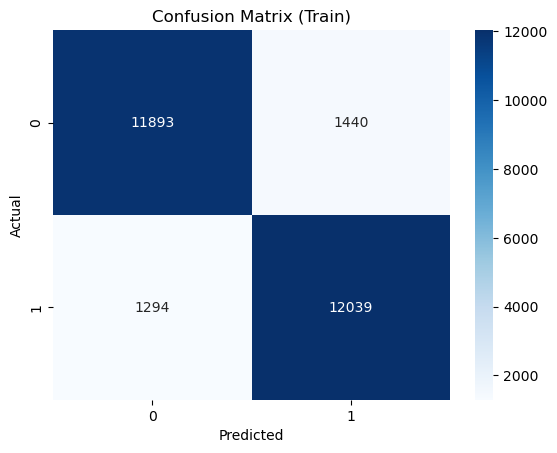


Metryki dla danych testowych:
Accuracy: 0.8378
AUC: 0.8003
F1: 0.6818

Classification Report dla danych testowych:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3741
           1       0.64      0.73      0.68      1172

    accuracy                           0.84      4913
   macro avg       0.78      0.80      0.79      4913
weighted avg       0.85      0.84      0.84      4913



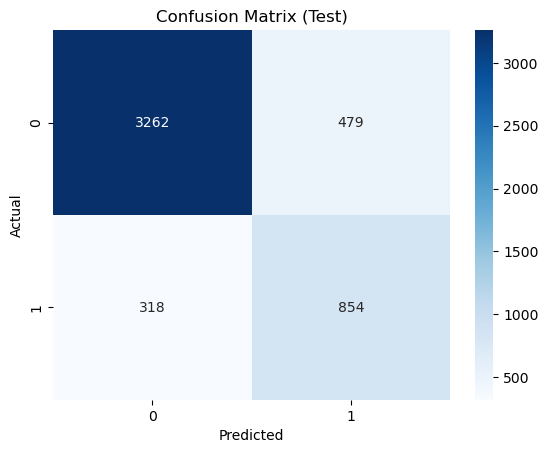

In [48]:
grid_randomforest = grid_search.best_estimator_
grid_randomforest.fit(X_resampled, y_resampled)
evaluate_model(grid_randomforest, X_resampled, y_resampled, X_test, y_test)

#### Sprawdzanie ważności cech

Teraz sprawdzimy **ważność cech** (feature importance) w naszym modelu lasu losowego. Ważność cech pokaże, które zmienne miały największy wpływ na decyzje podejmowane przez model.


In [49]:
feature_importances = grid_randomforest.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Cecha': feature_names,
    'Ważność': feature_importances
}).sort_values(by='Ważność', ascending=False)

print(importance_df[:10])

                         Cecha   Ważność
19  relationship_Not-in-family  0.150282
0                          age  0.141769
21      relationship_Own-child  0.117696
4                  net.capital  0.110858
3               hours.per.week  0.094353
2                education.num  0.090623
22      relationship_Unmarried  0.080111
11    occupation_Other-service  0.034408
6      occupation_Craft-repair  0.022343
1                       fnlwgt  0.017994


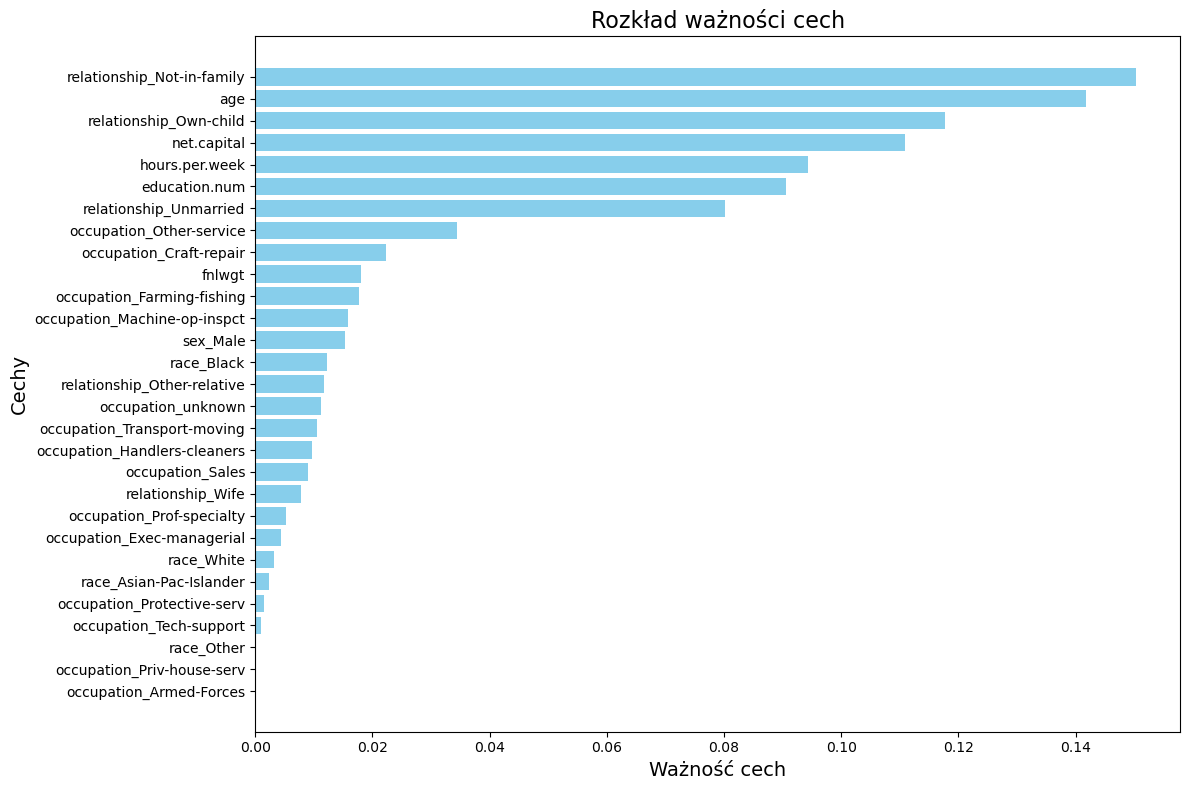

In [50]:
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Cecha'], importance_df['Ważność'], color='skyblue')
plt.xlabel('Ważność cech', fontsize=14)
plt.ylabel('Cechy', fontsize=14)
plt.title('Rozkład ważności cech', fontsize=16)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


Na podstawie analizy ważności cech w naszym modelu lasu losowego zidentyfikowaliśmy zmienne, które miały największy wpływ na decyzje podejmowane przez model. 
**Najważniejsze cechy**:
- Największy wpływ na decyzje modelu miały zmienne: `age`, `relationship_Not-in-family`, i `education.num`.
- Są to kluczowe zmienne, które najlepiej wyjaśniają zmienną celu w naszym modelu.

### Interpretacja modelu – wartości SHAP

Na podstawie analizy wartości SHAP w naszym modelu lasu losowego zidentyfikujemy zmienne, które miały największy wpływ na decyzje podejmowane przez model. 

Wykorzystanie wartości SHAP pozwoliło na dokładną interpretację zarówno globalnych, jak i lokalnych wpływów zmiennych, co czyni je nieocenionym narzędziem w analizie modeli predykcyjnych.


In [51]:
# Obliczanie wartości SHAP

explainer = shap.TreeExplainer(grid_randomforest)
shap_values = explainer.shap_values(X_test)
print(shap_values.shape)

(4913, 29, 2)


In [52]:
shap_values_class_1 = shap_values[:, :, 1]
print(shap_values_class_1.shape)


(4913, 29)


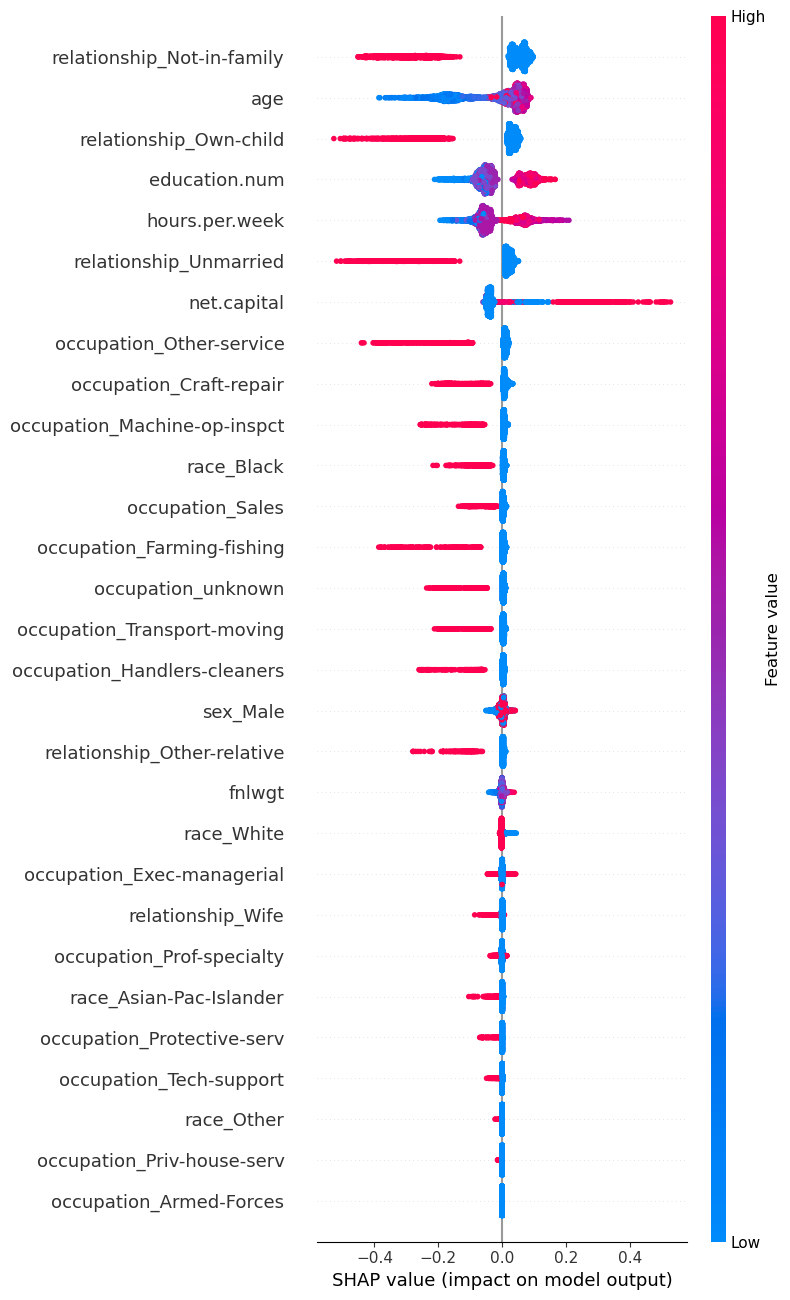

In [53]:
# Wizualizacja wartości SHAP
shap.summary_plot(shap_values_class_1, X_test, max_display=X_test.shape[1])


#### Jak interpretować wykres?
1. **Ranking cech**:
   - Cechy na wykresie są uporządkowane od góry do dołu według ich wpływu na wyniki modelu. 
   - Wyżej znajdują się cechy o większym wpływie na decyzje modelu, np. `relationship_Not-in-family`, `education.num` i `age`.

2. **Kolory**:
   - **Różowy (High)**: Oznacza wyższe wartości danej cechy.
   - **Niebieski (Low)**: Oznacza niższe wartości danej cechy.

3. **Wpływ na wynik modelu**:
   - Oś pozioma reprezentuje wartość SHAP, czyli wpływ danej cechy na predykcję modelu:
     - Wartości dodatnie przesuwają przewidywanie w stronę jednej klasy (np. pozytywnej).
     - Wartości ujemne przesuwają przewidywanie w stronę drugiej klasy (np. negatywnej).

4. **Rozkład punktów**:
   - Każdy punkt na wykresie reprezentuje jedną obserwację z danych testowych.
   - Im bardziej punkt przesunięty w prawo lub lewo, tym większy wpływ danej cechy na predykcję modelu dla tej obserwacji.

#### Dla naszego zbioru danych:
- **`relationship_Not-in-family`**:
  - Wyższe wartości tej cechy (różowe punkty) mają negatywny wpływ na wynik modelu, co oznacza przesunięcie predykcji w stronę klasy negatywnej. Oznacza to, że osoby, których status relacji to not in family, mają mniejsze szanse na zarabianie ≥50 000 USD rocznie.
  - Niższe wartości (niebieskie punkty) przesuwają wynik w stronę klasy pozytywnej. Oznacza to, że osoby, których status relacji nie wynosi not in family, mają większe szanse na zarabianie ≥50 000 USD rocznie.

- **`education.num`**:
  - Wyższy poziom edukacji (różowe punkty) zwiększa szanse na przypisanie obserwacji do klasy pozytywnej. 
  - Niższy poziom edykacji ma znaczny wpływ na przypisanie obserwacji do klasy negatywnej.
- **`age`**:
  - Wpływ wieku zależy od wartości tej cechy. Zarówno wysokie, jak i niskie wartości mogą mieć różny wpływ, co jest widoczne na wykresie w postaci rozkładu punktów po obu stronach osi poziomej.


In [54]:
# Obliczenie wartości SHAP dla jednego przykładu
index = 0  # indeks obserwacji w X_test
shap.force_plot(
    explainer.expected_value[1],  # wartość bazowa modelu dla klasy pozytywnej
    shap_values_class_1[index],       # wartości SHAP dla tej obserwacji
    X_test.iloc[index],          # dane wejściowe dla tej obserwacji
    feature_names=X_test.columns # nazwy cech
)


## 4. Budowa modelu - Bagging (Bootstrap Aggregating)


### Bagging Classifier

W przypadku modelu **Bagging Classifier** zastosowano wyszukiwanie optymalnych parametrów przy użyciu **GridSearchCV**. Główne hiperparametry i ich znaczenie to:

- **base_estimator**:  
  Model bazowy stosowany w baggingu. W tym przypadku wybrano **DecisionTreeClassifier** z ograniczeniami:  
  - **max_depth**: Maksymalna głębokość drzewa (ustawiono na `5`, aby zapobiec przeuczeniu).  
  - **min_samples_split**: Minimalna liczba próbek wymagana do podziału węzła (`10`).  
  - **min_samples_leaf**: Minimalna liczba próbek w liściu drzewa (`5`).

- **n_estimators**:  
  Liczba modeli bazowych tworzonych w baggingu. Większa liczba modeli poprawia stabilność, ale zwiększa czas trenowania.  
  Testowano wartości `[3, 5, 10, 20, 30, 50, 100]`.

- **max_samples**:  
  Proporcja próbek treningowych używanych do trenowania każdego modelu bazowego. Mniejsze wartości zwiększają różnorodność modeli.  
  Sprawdzono wartości `[0.5, 0.7, 1.0]`.

- **max_features**:  
  Proporcja cech losowanych do każdego modelu bazowego. Mniejsze wartości mogą zmniejszyć przeuczenie, zwiększając różnorodność modeli.  
  Testowano wartości `[0.5, 0.7, 1.0]`.


In [55]:
model = BaggingClassifier(random_state=42)

param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=20, min_samples_split=10, min_samples_leaf=5)],
    'n_estimators': [3, 5, 10, 20, 30],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
}


In [56]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,  
    verbose=2, 
    n_jobs=-1  
)

In [57]:
grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END base_estimator=DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10), max_features=0.5, max_samples=0.5, n_estimators=3; total time=   0.1s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10), max_features=0.5, max_samples=0.5, n_estimators=3; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10), max_features=0.5, max_samples=0.5, n_estimators=3; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10), max_features=0.5, max_samples=0.5, n_estimators=3; total time=   0.1s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10), max_features=0.5, max_samples=0.5, n_estimators=3; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=20, min_sam

GridSearchCV(cv=5, estimator=BaggingClassifier(random_state=42), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=20,
                                                                   min_samples_leaf=5,
                                                                   min_samples_split=10)],
                         'max_features': [0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.7, 1.0],
                         'n_estimators': [3, 5, 10, 20, 30]},
             scoring='accuracy', verbose=2)

In [58]:
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik: {grid_search.best_score_:0.2f}")

Najlepsze parametry: {'base_estimator': DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10), 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 30}
Najlepszy wynik: 0.88


Metryki dla danych treningowych:
Accuracy: 0.9368
AUC: 0.9368
F1: 0.9373

Classification Report dla danych treningowych:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     13333
           1       0.93      0.95      0.94     13333

    accuracy                           0.94     26666
   macro avg       0.94      0.94      0.94     26666
weighted avg       0.94      0.94      0.94     26666



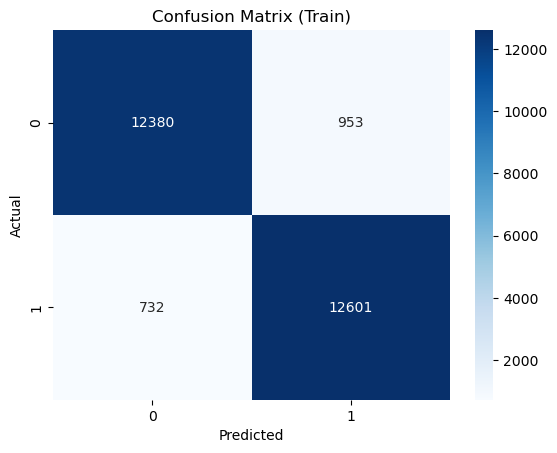


Metryki dla danych testowych:
Accuracy: 0.8366
AUC: 0.7978
F1: 0.6787

Classification Report dla danych testowych:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3741
           1       0.64      0.72      0.68      1172

    accuracy                           0.84      4913
   macro avg       0.77      0.80      0.78      4913
weighted avg       0.85      0.84      0.84      4913



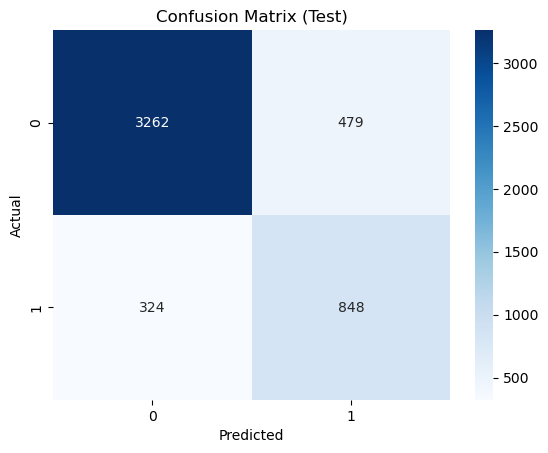

In [59]:
grid_bagging = grid_search.best_estimator_
grid_bagging.fit(X_resampled, y_resampled)
evaluate_model(grid_bagging, X_resampled, y_resampled, X_test, y_test)

### Interpretacja modelu – wartości SHAP
